In [1]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from tqdm.notebook import tqdm as tqdm
import jax
import jax.numpy as jnp
from jax.experimental.optimizers import adam
from jax.experimental.stax import *
from jax import random, jit
import numpy as np
import glob
import skimage.io as skio
import skimage as sk
from skimage.transform import resize, rescale
from livelossplot import PlotLosses

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.transforms import Compose, ColorJitter, Resize, ToTensor

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.transforms import *

import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim


## Data Loading

In [ ]:
%%capture
if not os.path.exists('/content/imm_face_db'):
    !wget http://www2.imm.dtu.dk/~aam/datasets/imm_face_db.zip
    !unzip 'imm_face_db.zip'    
    !rm -r 'imm_face_db.zip'

In [2]:
class ImmFaceDb(Dataset):
    def __init__(self, root_dir, keypoints=[-6], transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        img_paths = glob.glob(root_dir + '*.jpg')
        img_paths.sort()
        self.img_paths = np.array(img_paths)
        
        asf_paths = glob.glob(root_dir + '*.asf')
        asf_paths.sort()
        self.asf_paths = np.array(asf_paths)

        self.keypoints = keypoints
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_paths = self.img_paths[idx]
        asf_paths = self.asf_paths[idx]

        imgs = read(img_paths, color=False)
        imgs = imgs - 0.5

        asf_data = self.read_asf(asf_paths, self.keypoints)
        asf_data = np.column_stack((asf_data[0], asf_data[1]))
        sample = {'x': imgs, 'y': asf_data}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def read_asf(self, file, keypoints=None):
        """Reads x, y points from asf file

        Args:
            file (str): path to asf file

        Returns:
            np.ndarray, np.ndarray: list of x points, list of y points
        """
        if keypoints:
            data = np.genfromtxt(file, skip_header=16, skip_footer=1, usecols=(2, 3))[keypoints, :]
        else:
            data = np.genfromtxt(file, skip_header=16, skip_footer=1, usecols=(2, 3))[:, :]
        return data[:, 0], data[:, 1]

In [33]:
from PIL import Image
    
def read(img, color=True):
    # read in the image
    img = skio.imread(img, as_gray=not color)
    
    if not color:
        img = np.expand_dims(img, axis=2)

    # convert to double
    img = sk.img_as_float(img)
    return img

class ColorJitterX(object):
    def __call__(self, sample):
        image, points = sample['x'], sample['y']
        brightness = np.random.random()
        contrast = np.random.random()
        image = image[:, :, 0] * contrast + brightness
        image = image[..., None]
        return {'x': image.transpose(2, 0, 1), 'y': points}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, points = sample['x'], sample['y']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        points[:, 0] = points[:, 0] * w
        points[:, 1] = points[:, 1] * h
        points = points - [left, top]
        points[:, 0] = points[:, 0] / new_w
        points[:, 1] = points[:, 1] / new_h
        
        return {'x': image, 'y': points}

class Rescale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        image = sample['x']
        image = rescale(image[:, :, 0], self.scale)[..., None]
        return {'x': image, 'y':sample['y']}

In [34]:
batch_size = 32
validation_split = 0.2
height = 180
width = 240
channels = 1

transforms = Compose([
            Rescale(0.45),
            RandomCrop((height, width)),
            ColorJitterX(),
        ])

dataset = ImmFaceDb('imm_face_db/', keypoints=None, transform=transforms)

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler) 

torch.Size([1, 180, 240])


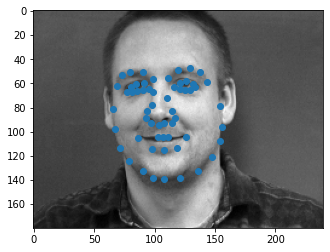

torch.Size([1, 180, 240])


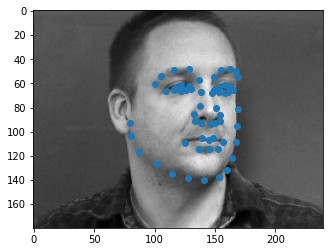

torch.Size([1, 180, 240])


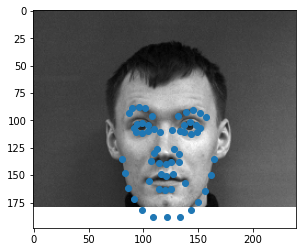

torch.Size([1, 180, 240])


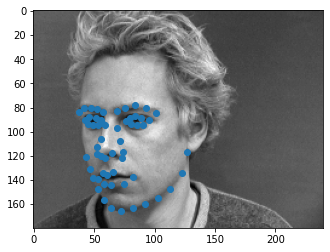

In [36]:
for i, sample in enumerate(train_loader):
    if i > 3:
        break
    
    img = sample['x'][0]
    print(img.shape)
    points = sample['y'][0]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.scatter(points[:, 0] * img.shape[2], points[:, 1] * img.shape[1])
    plt.show()

In [68]:
from torch.nn import *
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(172800, 128)
        self.fc2 = nn.Linear(128, 58*2)

    # Defining the forward pass    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
net = Net()

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=172800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=116, bias=True)
)


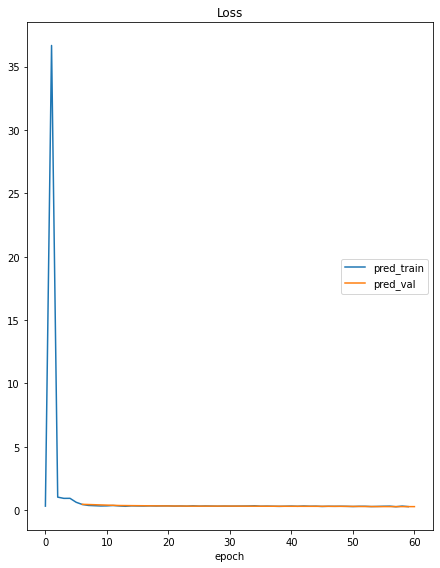

Loss
	pred_train       	 (min:    0.288, max:   36.664, cur:    0.288)
	pred_val         	 (min:    0.288, max:    0.470, cur:    0.288)


In [67]:
#Hyperparameters 
epochs = 10
lr = 1e-3

# Loss
criterion = nn.MSELoss()

# Create Plots
plt_groups = {'loss':[]}
plotlosses_model = PlotLosses(groups=plt_groups)
plt_groups['loss'].append('pred_train')
plt_groups['loss'].append('pred_val')

# Training Loop
device = torch.device("cpu")

if torch.cuda.is_available():
    print(f"Training on GPU")
    device = torch.device("cuda")

# Model
net = Net().double()
net = net.to(device)


# Optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)

iters = 0
for e in range(epochs):
    for batch_i, sample_batch in tqdm(enumerate(train_loader), leave=False, desc='iter', total=len(dataset) // batch_size):
        optimizer.zero_grad()   # zero the gradient buffers

        images = sample_batch['x']
        points = sample_batch['y']
        points = np.reshape(points, (points.shape[0], -1))
        target = points.to(device)

        output = net(images)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        plotlosses_model.update({'pred_train':loss.item()}, current_step=iters)
        iters += 1
    
    # get validation loss
    val_values = []
    for batch_i, sample_valid_batch in tqdm(enumerate(validation_loader), leave=False, desc='iter'):
        with torch.no_grad():
            images = sample_batch['x'].to(device)
            points = sample_batch['y']
            points = np.reshape(points, (points.shape[0], -1))
            target = points.to(device)
            
            output = net(images)            
            loss = criterion(output, target)

            val_values.append(loss.item())

        
    plotlosses_model.update({'pred_val':np.mean(val_values)}, current_step=iters)
    plotlosses_model.send()

In [69]:
torch.save({
        'epoch': e,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': np.mean(val_values)
        }, f'checkpoint_part2')


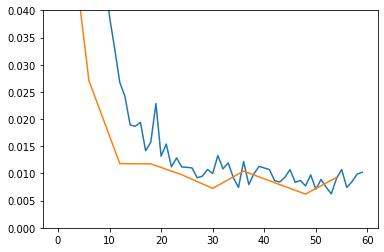

In [39]:
train_loss = [float(x[1]) for x in plotlosses_model.logger.log_history['pred_train']]
val_loss = [float(x[1]) for x in plotlosses_model.logger.log_history['pred_val']]
plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(0, len(train_loss), len(train_loss) // len(val_loss))[:len(val_loss)], val_loss)
plt.ylim(0, .04)
plt.show()

torch.Size([32, 1, 180, 240])


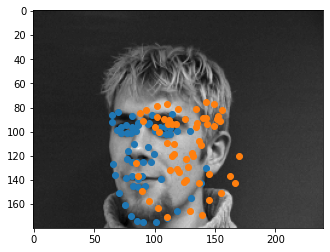

torch.Size([16, 1, 180, 240])


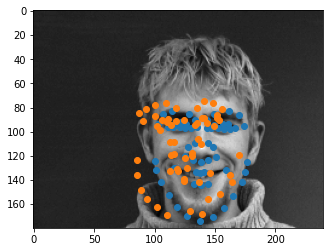

In [45]:
with torch.no_grad():
  for batch_i, sample_valid_batch in tqdm(enumerate(validation_loader), leave=False, desc='iter'):
      if batch_i > 10:
          break
      val_imgs = sample_valid_batch['x']
      val_points = sample_valid_batch['y']
      
      pred = net(val_imgs)
      pred = pred.reshape(val_points.shape)
      print(val_imgs.shape)
      plt.imshow(val_imgs[0].squeeze(), cmap='gray')
      plt.scatter(val_points[0, :, 0] * width, val_points[0, :, 1] * height)
      plt.scatter(pred[0, :, 0] * width, pred[0, :, 1] * height)
      plt.show()

In [44]:
for batch_i, sample_valid_batch in tqdm(enumerate(train_loader), leave=False, desc='iter'):
    if batch_i > 3:
        break
    val_imgs = sample_valid_batch['x'].numpy()
    val_points = sample_valid_batch['y'].numpy()
    pred = model(save_params, val_imgs)
    pred = pred.reshape(val_points.shape)
    plt.imshow(val_imgs[0] + 0.5, cmap='gray')
    plt.scatter(val_points[0, :, 0] * width, val_points[0, :, 1] * height)
    plt.scatter(pred[0, :, 0] * width, pred[0, :, 1] * height)
    plt.show()
    print(np.mean((val_points - pred)**2))

NameError: name 'model' is not defined

In [ ]:
plotlosses_model.send()